## IMPORTED MODULES 

In [1]:
import os
import numpy as np                 
import pandas as pd                
import matplotlib.pyplot as plt
import seaborn as sns 
import librosa
import librosa.display
from IPython.display import Audio  
plt.style.use('seaborn-white')
from scipy.signal import resample

# DATA PREPRATION MODULES
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# MODELING MODULES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling1D,LSTM ,Activation
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

/tmp/ipykernel_34/2476977642.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
2024-02-10 22:31:07.903994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 22:31:07.904091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 22:31:08.029515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LOADING THE DATA INTO DATAFRAME

In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk('DATASET FOLDER PATH'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        label = filename.split('_')[-1].split('.')[0].lower()
        labels.append(label)

df = pd.DataFrame()
df['path'] = paths
df['label'] = labels
df.head()

,path,label
0,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
1,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
2,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
3,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
4,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap


## DATA ANALYSIS

In [4]:
print(df.label.value_counts())
print("Total Data :" , df.label.value_counts().sum())

label
hap    1923
ang    1923
fea    1923
sad    1923
dis    1923
neu    1703
Name: count, dtype: int64
Total Data : 11318


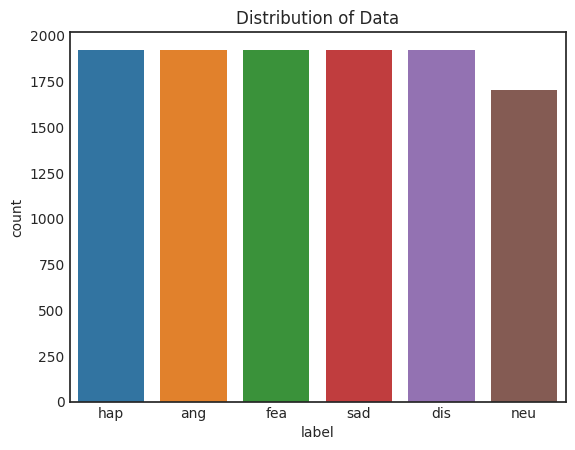

In [5]:
# Data Distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Data')
plt.show()

## AUGMENTATION 

In [6]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

# taking any example and checking for techniques.
path = path = 'ANY AUDIO FILE PATH FROM DATASET'
data, sample_rate = librosa.load(path)

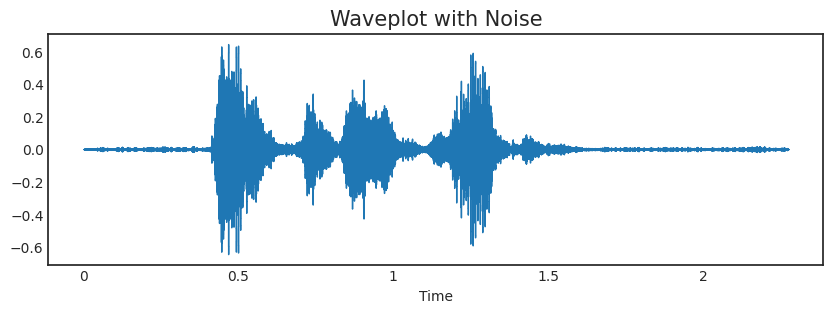

In [ ]:
plt.figure(figsize=(10, 3))
x = noise(data) 
y = resample(x, len(data))
librosa.display.waveshow(y, sr=sample_rate)
plt.title('Waveplot with Noise', size=15)
plt.show()

# Playing the audio with added noise
Audio(y, rate=sample_rate)

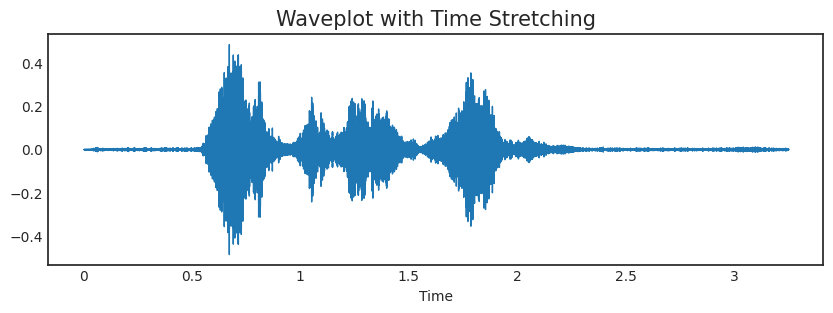

In [8]:
def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate=rate)

plt.figure(figsize=(10, 3))
x = stretch(data)  # Assuming data is loaded or defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Time Stretching', size=15)
plt.show()

# Playing the audio after time stretching
Audio(x, rate=sample_rate)

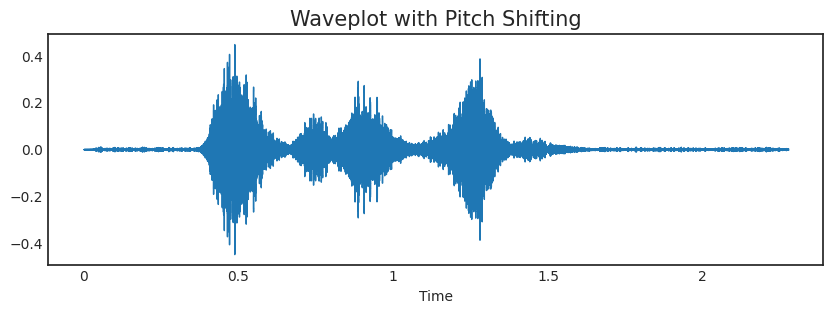

In [9]:
def shift(data, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

plt.figure(figsize=(10, 3))
x = shift(data)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

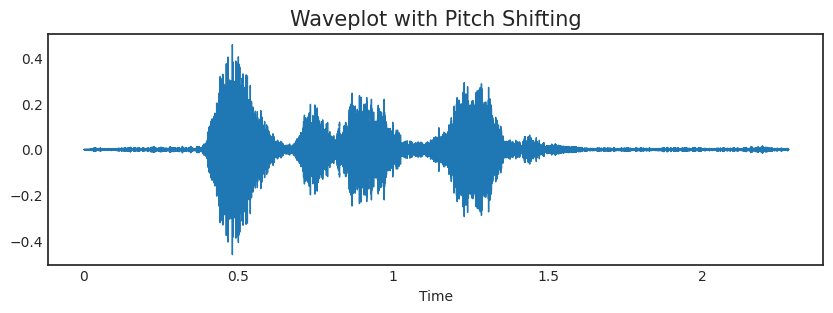

In [10]:
def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, n_steps=int(pitch_factor * 12), sr=sampling_rate)

plt.figure(figsize=(10, 3))
x = pitch(data, sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

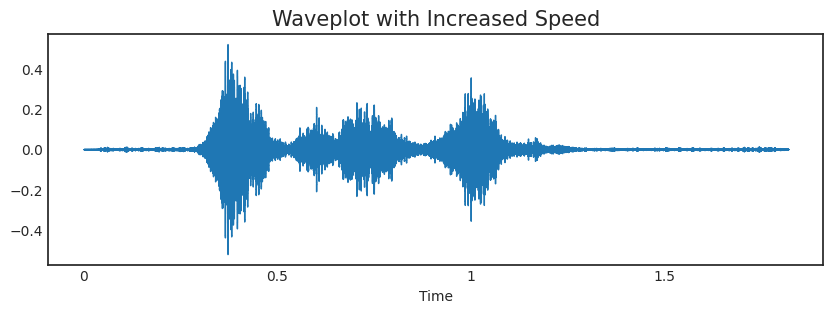

In [11]:
def higher_speed(data, sample_rate, speed_factor=1.25):
    return librosa.effects.time_stretch(y=data, rate=speed_factor)
plt.figure(figsize=(10, 3))
x = higher_speed(data, sample_rate)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Increased Speed', size=15)
plt.show()

# Playing the audio after increasing the speed
Audio(x, rate=sample_rate)

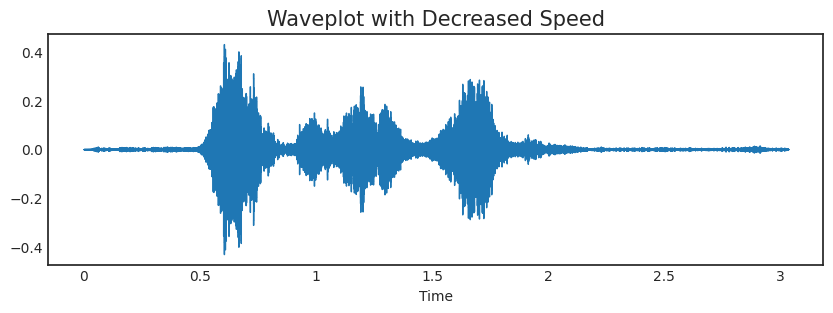

In [12]:
def lower_speed(data, speed_factor=0.75):
    return librosa.effects.time_stretch(data, rate=speed_factor)

plt.figure(figsize=(10, 3))
x = lower_speed(data)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Decreased Speed', size=15)
plt.show()

# Playing the audio after decreasing the speed
Audio(x, rate=sample_rate)

## FEATURE EXTRACTION 
### USING MFCC (Mel-Frequency Cepstral Coefficients)

In [13]:
def extract_features(data):
    
    result = np.array([])
    
    ## 58 n_mfcc    #sample_rate = 22050
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)# approximate resampling method.
    
    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))
    
    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))
    
    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) 
    
    #speed up
    higher_speed_data = higher_speed(data,sample_rate)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))
    
    #speed down
    lower_speed_data = higher_speed(data,sample_rate)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))
    
    return result

## Extracting Features From each audio [original & Augmented] and save them in CSV File 
- This process is done and i provided the CSV file in the inputs 
- It took 1.5 hour to extract all the features 
- Features Extracted = 79227 feature.

In [14]:
# Extracting Features Using get_features Function and save them in CSV file.
# X, Y = [], []
# for path, emotion in zip(paths, labels): 
#     features = get_features(path)
#     for elem in features:
#         X.append(elem)
#         Y.append(emotion)

# # Convert to DataFrame
# features_df = pd.DataFrame(X)
# features_df['label'] = Y

# # Save to CSV
# features_df.to_csv('/kaggle/working/audio_features.csv', index=False)

In [15]:
# Load the Extracted Features for the Model 
features_df = pd.read_csv('FEATURES CSV FILE PATH')

# Separate features and labels
X = features_df.drop('label', axis=1)
Y = features_df['label']

## Splitting data into training, testing

In [16]:
X = np.array(X)
Y = np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle = True)

print(f'X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}')
print(f'y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}')

X_train: 50704, X_val: 12676, X_test: 15846
y_train: 50704, y_val: 12676, y_test: 15846


## Normalization & One-hot Encoding for the Classification 

In [17]:
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) 
X_test = scaler.transform(X_test)

# One-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.transform(y_val.reshape(-1, 1)).toarray()  
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

In [18]:
# Reshape data
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Output the shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50704, 58, 1),
 (50704, 6),
 (12676, 58, 1),
 (12676, 6),
 (15846, 58, 1),
 (15846, 6))

## Model 
### CNN-LSTM

In [19]:
model = keras.Sequential()
input_shape = (X_train.shape[1], X_train.shape[2])

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layers
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Dense layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

num_classes = y_train.shape[1]
model.add(Dense(num_classes, activation='softmax'))

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 128)           512       
                                                                 
 batch_normalization (Batch  (None, 56, 128)           512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 56, 128)           0         
                                                                 
 dropout (Dropout)           (None, 56, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 54, 128)           49280     
                                                                 
 batch_normalization_1 (Bat  (None, 54, 128)           512       
 chNormalization)                                       

In [21]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=10, min_lr=0.000001)

In [22]:
from tensorflow.keras.models import load_model
# history = model.fit(X_train, y_train, epochs=75, batch_size=32, callbacks = [rlrp], validation_data=(X_val, y_val))
# Load the model
loaded_model = load_model('MODEL PATH')

Epoch 1/75


I0000 00:00:1707604368.870366     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1585/1585 [==============================] - 33s 14ms/step - loss: 1.4685 - accuracy: 0.3881 - val_loss: 1.2965 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 2/75
1585/1585 [==============================] - 22s 14ms/step - loss: 1.3038 - accuracy: 0.4662 - val_loss: 1.2185 - val_accuracy: 0.4961 - lr: 0.0010
Epoch 3/75
1585/1585 [==============================] - 22s 14ms/step - loss: 1.2467 - accuracy: 0.4911 - val_loss: 1.1958 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 4/75
1585/1585 [==============================] - 21s 14ms/step - loss: 1.2139 - accuracy: 0.5100 - val_loss: 1.1292 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 5/75
1585/1585 [==============================] - 22s 14ms/step - loss: 1.1826 - accuracy: 0.5218 - val_loss: 1.1058 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 6/75
1585/1585 [==============================] - 21s 14ms/step - loss: 1.1582 - accuracy: 0.5301 - val_loss: 1.0750 - val_accuracy: 0.5665 - lr: 0.0010
Epoch 7/75
1585/1585 [==============================] - 2

In [23]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")

Training Accuracy: 92.01%
Testing Accuracy: 78.00%


In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

496/496 [==============================] - 3s 5ms/step - loss: 0.6072 - accuracy: 0.7800
Test Loss: 0.6071783304214478
Test Accuracy: 0.7800076007843018


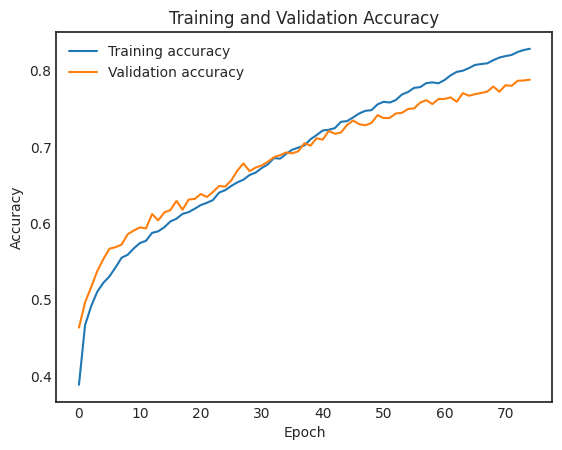

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy') # watch the Error in "history" because of loaded MODEL 
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes)
print(report)

496/496 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2693
           1       0.76      0.74      0.75      2692
           2       0.80      0.71      0.75      2692
           3       0.81      0.73      0.77      2693
           4       0.77      0.79      0.78      2384
           5       0.72      0.83      0.78      2692

    accuracy                           0.78     15846
   macro avg       0.78      0.78      0.78     15846
weighted avg       0.78      0.78      0.78     15846



496/496 [==============================] - 2s 4ms/step


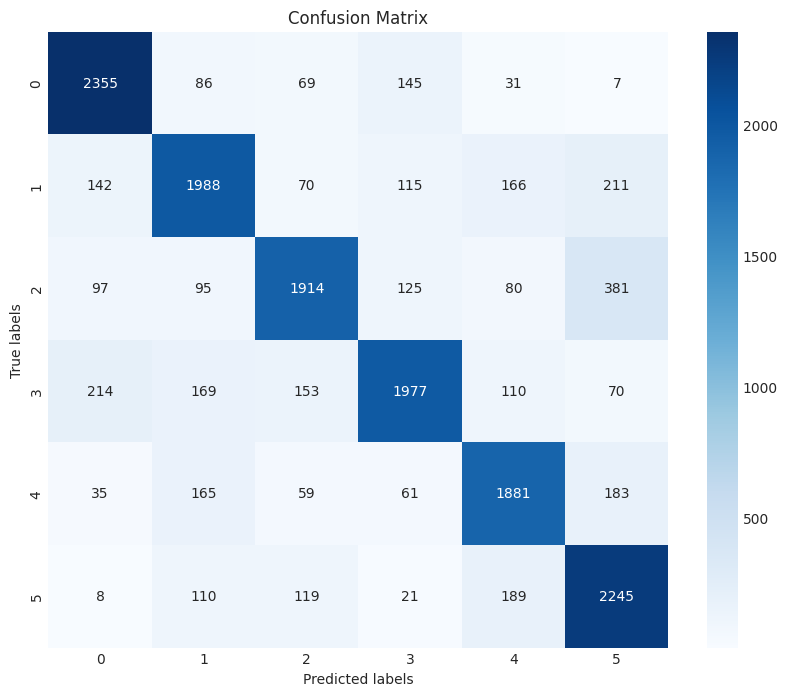

In [27]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()